# Telegram Analysis

## Prepare environment

In [1]:
"""
Set flag to true, if you work in visual studio code (connected to custom docker)
Set flag to false, if you work in browser (jupyter notebook ui from custom docker)
If flag set to true, you work an a spot check
"""
FLAG_LOCAL = True

In [2]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Import url libs
from urllib.parse import urlparse
from collections import Counter

# Set graph widget (used by jupyter notebook)
#%matplotlib notebook   #interactive graphs
%matplotlib inline

In [3]:
# Install and import Graph Lib
import networkx as nx
! pip install pydot

In [4]:
# Install and import  JSON Lib
! pip install demjson
import demjson

In [5]:
# Install and import Natural Language Toolkit
! pip install nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Install and import WordCloud
! pip install wordcloud
from wordcloud import WordCloud

In [7]:
# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

In [8]:
# Set env vars
if(FLAG_LOCAL == True):
    dir_var = "./work/notebooks/"
else:
    dir_var = "./"

dir_var_output = dir_var + "output/"

# Debug output
! echo "- Workdir -"
! ls -al $dir_var

! echo
! echo "- Outputdir -"
! ls -al $dir_var_output

- Workdir -
total 6252
drwxr-xr-x 7 root   root      224 Dec 21 17:52 .
drwxr-xr-x 9 root   root      288 Dec 21 16:06 ..
drwxr-xr-x 5 jovyan users     160 Dec 20 10:22 data
-rw-r--r-- 1 jovyan users    5342 Dec 20 10:42 inputFiles.csv
drwxr-xr-x 3 jovyan users      96 Dec 20 10:30 .ipynb_checkpoints
drwxr-xr-x 9 jovyan users     288 Dec 21 17:52 output
-rwxr-xr-x 1 jovyan users 6391294 Dec 22 11:43 Telegram.ipynb

- Outputdir -
total 4696
drwxr-xr-x 9 jovyan users     288 Dec 21 17:52 .
drwxr-xr-x 7 root   root      224 Dec 21 17:52 ..
-rw-r--r-- 1 jovyan users       0 Dec 21 14:19 .gitkeep
-rw-r--r-- 1 jovyan users 1314686 Dec 22 08:48 graph.png
-rw-r--r-- 1 jovyan users  491007 Dec 22 08:48 wordcloud-global.png
-rw-r--r-- 1 jovyan users  547751 Dec 22 08:47 wordcloud-pc-evaHerman.png
-rw-r--r-- 1 jovyan users  521999 Dec 22 08:47 wordcloud-pc-hildmann.png
-rw-r--r-- 1 jovyan users  526440 Dec 22 08:47 wordcloud-pc-janich.png
-rw-r--r-- 1 jovyan users  483883 Dec 22 08:47 wordcloud-p

## Global functions

In [9]:
"""
Check if text is json formatted

param   text        InputText
param   singleMode  Boolean (set to true, if text is part of a message)
"""
def gloCheckIsTextJsonFormatted(text, singleMode):
    textString = str(text)
    if      (singleMode == False and textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    elif    (singleMode == True and textString.startswith("{") == True and textString.endswith("}") == True):
        return True
    else:
        return False

In [10]:
dictGloStopwatches = dict()

# Start timer (for reporting)
def gloStartStopwatch(key):
    print("[Stopwatch started >>" + str(key) + "<<]")
    dictGloStopwatches[key] = time.time()

# Stop timer (for reporting)
def gloStopStopwatch(key):
    endTime     = time.time()
    startTime   = dictGloStopwatches[key]
    print("[Stopwatch stopped >>" + str(key) + "<< (" + '{:5.3f}s'.format(endTime-startTime) + ")]")

In [11]:
# Generate unique chat name
def gloConvertToSafeChatName(chatName):
    chatName = chatName.encode('ascii', 'ignore')
    chatName = chatName.decode('ascii')
    return chatName[:30]  

## Process input jobs

In [12]:
# Read jobs from file
dfInputFiles = pd.read_csv(dir_var + "inputFiles.csv", sep=";")

In [13]:
# See description above (generate spot check)
if(FLAG_LOCAL == True):
    dfFilter = pd.DataFrame()

    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Xavier Naidoo")])
    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Oliver Janich")])
    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Eva Herman")])
    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("ATTILA HILDMANN")])

    dfInputFiles = dfFilter

### Overview input jobs

In [14]:
dfInputFiles

inputName  \
12  Xavier Naidoo (inoffiziell)   
1     Oliver Janich oeffentlich   
11         Eva Herman Offiziell   
2      ATTILA HILDMANN OFFICIAL   

                                        inputPath       inputType  \
12     DS-08-10-2020/ChatExport_2020-09-25-xavier  public_channel   
1      DS-08-10-2020/ChatExport_2020-09-25-janich  public_channel   
11  DS-08-10-2020/ChatExport_2020-09-27-evaherman  public_channel   
2    DS-08-10-2020/ChatExport_2020-09-25-hildmann  public_channel   

        inputId inputDesc inputDownloadType  
12   9874390332       NaN               all  
1    9808932799       NaN               all  
11   9915108907       NaN               all  
2   10034163583       NaN               all

### Transform data into DataFrmaes

In [15]:
# Convert to DataFrame Meta (Chat Meta)
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + "data/" + filePath + "/result.json", encoding='utf-8')
    return dF

# Convert to DataFrame Messages (Chat Messages)
def convertToDataFrameMessages(filePath, dictMeta):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

In [16]:
"""
Get params from extractedTextData
See cell below (key)
"""
def getExtractedTextDataParam(key, extractedTextData):
    a,b,c,d,e,f,g = extractedTextData
    switcher = {
        0: a,
        1: b,
        2: c,
        3: d,
        4: e,
        5: f,
        6: g
    }
    return switcher.get(key)

In [17]:
# TODO: href, mention and hashtags in normal text?

"""
Extract text data (see cell above key)
See cell above (key)

param   procIsJsonFormatted Boolean (is text json formatted?)
param   text                String  (text from message) 

return
a   procText            Plain Text
b   processedURLs       Array of URLs in Text
c   processedHashtags   Array of Hashtags in Text
d   processedBolds      Array of Bold Items in Text
e   processedItalics    Array of Italic Items in Text
f   processedUnderlines Array of Underlined Items in Text
g   processedEmails     Array of E-Mails in Text
"""
def extractTextData(procIsJsonFormatted, text):
    
    # 3 returns in this function...
    
    processedURLs       = list()
    processedHashtags   = list()
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(procIsJsonFormatted != True):
        #Is not JSON formatted (return normal text)
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is is JSON formatted (try to parse)
        try:
            returnList = []
            jsonList = demjson.decode(str(text), encoding='utf8')

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isJsonSubString = gloCheckIsTextJsonFormatted(messageString, singleMode = True)

                if(isJsonSubString):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        processedHashtags.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unkown json type >>" + subJsonType + "<< (ignore) >>" + text + "<<")

                else:
                    # Is no json formatted sub string (append text)
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            # Parser error (set inputText to returnText)
            print("- Warn: Json parser error (set inputText to returnText) >>" + text + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

In [18]:
def evalIsValidText(procTDTextSize):
    if(procTDTextSize > 0):
        return True
    else:
        return False

In [19]:
def evalContainsSomething(att):
    if(str(att) == "nan"):
        return False
    else:
        return True

In [20]:
gloStartStopwatch("Extract Text Data")

# Add Key = filePath / Value = DataFrame (Chat Meta)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Chat Message)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    gloStartStopwatch("TD-Extract " + fP)
    dfMessages                          = convertToDataFrameMessages(fP, dictMeta)
    
    # Get chat attributes and check if message is json formatted
    dfMessages["procChatFilePath"]      = fP
    dfMessages["procChatType"]          = dictMeta[fP].type.iloc[0]
    dfMessages["procIsJsonFormatted"]   = dfMessages["text"].apply(gloCheckIsTextJsonFormatted, singleMode = False)
    
    # Extract Text Data
    dfMessages["tmpExtractedTD"]        = dfMessages.apply(lambda x: extractTextData(x.procIsJsonFormatted, x.text), axis=1)

    # Extract Text Data (params)
    dfMessages["procTDText"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(0, x.tmpExtractedTD), axis=1)
    dfMessages["procTDURLs"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(1, x.tmpExtractedTD), axis=1)
    dfMessages["procTDHashtags"]        = dfMessages.apply(lambda x: getExtractedTextDataParam(2, x.tmpExtractedTD), axis=1)
    dfMessages["procTDBolds"]           = dfMessages.apply(lambda x: getExtractedTextDataParam(3, x.tmpExtractedTD), axis=1)
    dfMessages["procTDItalics"]         = dfMessages.apply(lambda x: getExtractedTextDataParam(4, x.tmpExtractedTD), axis=1)
    dfMessages["procTDUnderlines"]      = dfMessages.apply(lambda x: getExtractedTextDataParam(5, x.tmpExtractedTD), axis=1)
    dfMessages["procTDEmails"]          = dfMessages.apply(lambda x: getExtractedTextDataParam(6, x.tmpExtractedTD), axis=1)

    # Calc text size
    dfMessages["procTDTextSize"]        = dfMessages["procTDText"].str.len()

    # Evaluate attributes
    dfMessages["procEvalIsValidText"]   = dfMessages.procTDTextSize.apply(evalIsValidText)
    dfMessages["procEvalContainsPhoto"] = dfMessages.photo.apply(evalContainsSomething)
    dfMessages["procEvalContainsFile"]  = dfMessages.file.apply(evalContainsSomething) 
    dfMessages["procEvalIsEdited"]      = dfMessages.edited.apply(evalContainsSomething) 
    
    dictMessages[fP] = dfMessages
    gloStopStopwatch("TD-Extract " + fP)

    
# All Messages to DataFrame
gloStartStopwatch("Generate global DataFrame")
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)
gloStopStopwatch("Generate global DataFrame")

gloStopStopwatch("Extract Text Data")

[Stopwatch started >>Extract Text Data<<]
[Stopwatch started >>TD-Extract DS-08-10-2020/ChatExport_2020-09-25-xavier<<]
[Stopwatch stopped >>TD-Extract DS-08-10-2020/ChatExport_2020-09-25-xavier<< (10.907s)]
[Stopwatch started >>TD-Extract DS-08-10-2020/ChatExport_2020-09-25-janich<<]
[Stopwatch stopped >>TD-Extract DS-08-10-2020/ChatExport_2020-09-25-janich<< (57.372s)]
[Stopwatch started >>TD-Extract DS-08-10-2020/ChatExport_2020-09-27-evaherman<<]
[Stopwatch stopped >>TD-Extract DS-08-10-2020/ChatExport_2020-09-27-evaherman<< (36.264s)]
[Stopwatch started >>TD-Extract DS-08-10-2020/ChatExport_2020-09-25-hildmann<<]
[Stopwatch stopped >>TD-Extract DS-08-10-2020/ChatExport_2020-09-25-hildmann<< (21.352s)]
[Stopwatch started >>Generate global DataFrame<<]
[Stopwatch stopped >>Generate global DataFrame<< (0.592s)]
[Stopwatch stopped >>Extract Text Data<< (127.180s)]


## Queries

### Type of channels (and only included in)

In [21]:
dfInputFiles.inputType.value_counts()

public_channel    4
Name: inputType, dtype: int64

In [22]:
#dfAllDataMessages.columns.difference(dfAllDataMessages[dfAllDataMessages.procChatType == "public_channel"].dropna(how='all', axis=1).columns)

In [23]:
#dfAllDataMessages.columns.difference(dfAllDataMessages[dfAllDataMessages.procChatType == "public_supergroup"].dropna(how='all', axis=1).columns)

In [24]:
# No enough data
#dfAllDataMessages.columns.difference(dfAllDataMessages[dfAllDataMessages.procChatType == "private_supergroup"].dropna(how='all', axis=1).columns)

### Define queries

In [25]:
def queryChatId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [26]:
def queryChatName(filePath):
    dfMeta      = dictMeta[filePath].copy()
    chatName    = str(dfMeta["name"].iloc[0])
    chatName    = gloConvertToSafeChatName(chatName)
    return chatName

In [27]:
def queryChatType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [28]:
def queryNumberOfMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [29]:
def queryNumberOfFormattedTextMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procIsJsonFormatted == True]
    return len(dfMessages.index)

In [30]:
def queryNumberOfValidTextMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procEvalIsValidText == True]
    return len(dfMessages.index)

In [31]:
def queryNumberOfPhotos(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsPhoto == True]
    return len(dfMessages.index)

In [32]:
def queryNumberOfFiles(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsFile == True]
    return len(dfMessages.index)

In [33]:
def queryNumberOfEditedMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.procEvalIsEdited == True]
    return len(dfMessages.index)

### Execute queries

In [34]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["qryChatId"]                        = dfQueryMeta.inputPath.apply(queryChatId)
dfQueryMeta["qryChatName"]                      = dfQueryMeta.inputPath.apply(queryChatName)
dfQueryMeta["qryChatType"]                      = dfQueryMeta.inputPath.apply(queryChatType)
dfQueryMeta["qryNumberOfMessages"]              = dfQueryMeta.inputPath.apply(queryNumberOfMessages)
dfQueryMeta["qryNumberOfFormattedTextMessages"] = dfQueryMeta.inputPath.apply(queryNumberOfFormattedTextMessages)
dfQueryMeta["qryNumberOfValidTextMessages"]     = dfQueryMeta.inputPath.apply(queryNumberOfValidTextMessages)
dfQueryMeta["qryNumberOfPhotos"]                = dfQueryMeta.inputPath.apply(queryNumberOfPhotos)
dfQueryMeta["qryNumberOfFiles"]                 = dfQueryMeta.inputPath.apply(queryNumberOfFiles)
dfQueryMeta["qryNumberOfEditedMessages"]        = dfQueryMeta.inputPath.apply(queryNumberOfEditedMessages)

dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False)

inputPath    qryChatId  \
1      DS-08-10-2020/ChatExport_2020-09-25-janich   9808932799   
11  DS-08-10-2020/ChatExport_2020-09-27-evaherman   9915108907   
2    DS-08-10-2020/ChatExport_2020-09-25-hildmann  10034163583   
12     DS-08-10-2020/ChatExport_2020-09-25-xavier   9874390332   

                    qryChatName     qryChatType  qryNumberOfMessages  \
1       Oliver Janich ffentlich  public_channel                35040   
11         Eva Herman Offiziell  public_channel                26724   
2     ATTILA HILDMANN OFFICIAL   public_channel                22204   
12  Xavier Naidoo (inoffiziell)  public_channel                 6463   

    qryNumberOfFormattedTextMessages  qryNumberOfValidTextMessages  \
1                              24511                         22673   
11                             20197                          8925   
2                              10026                         13965   
12                              4285                          4995   

    qryNumberOfPhotos  qryNumberOfFiles  qryNumberOfEditedMessages  
1                5604              4579                       3542  
11               3068              1354                       1768  
2                7840              1935                       3183  
12               1874              1007                       1770

### Plot queries

In [193]:
# Auto label query plot
def autolabel(rects, ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    Copied from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html (22.12.2020)
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [194]:
def queryMetaPlotter():
    # Init data
    dataLabels                          = list()
    dataNumberOfMesssages               = list()
    dataNumberOfFormattedTextMessages   = list()
    dataNumberOfValidTextMessages       = list()
    dataNumberOfEditedMessages          = list()
    dataNumberOfPhotos                  = list()
    dataNumberOfFiles                   = list()

    # Iterate over Meta DataFrame
    for index, row in dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False).iterrows():

        # Get attributes
        dataLabels                          .append(row.qryChatName)
        dataNumberOfMesssages               .append(row.qryNumberOfMessages)
        dataNumberOfFormattedTextMessages   .append(row.qryNumberOfFormattedTextMessages)
        dataNumberOfValidTextMessages       .append(row.qryNumberOfValidTextMessages)
        dataNumberOfEditedMessages          .append(row.qryNumberOfEditedMessages)
        dataNumberOfPhotos                  .append(row.qryNumberOfPhotos)
        dataNumberOfFiles                   .append(row.qryNumberOfFiles)

    # Convert list to array
    dataLabels                          = np.array(dataLabels)
    dataNumberOfMesssages               = np.array(dataNumberOfMesssages)
    dataNumberOfFormattedTextMessages   = np.array(dataNumberOfFormattedTextMessages)
    dataNumberOfValidTextMessages       = np.array(dataNumberOfValidTextMessages)
    dataNumberOfEditedMessages          = np.array(dataNumberOfEditedMessages)
    dataNumberOfPhotos                  = np.array(dataNumberOfPhotos)
    dataNumberOfFiles                   = np.array(dataNumberOfFiles)

    # Draw
    fig, ax = plt.subplots()
    x = np.arange(len(dataLabels))

    barWidth = 0.1

    fig.set_figwidth(16)
    fig.set_figheight(9)

    r1 = x
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]

    rects1 = ax.bar(r1, dataNumberOfMesssages, barWidth, label='Messages')
    rects2 = ax.bar(r2, dataNumberOfFormattedTextMessages, barWidth, label='Formatted Messsages')
    rects3 = ax.bar(r3, dataNumberOfValidTextMessages, barWidth, label='Valid Messages')

    rects4 = ax.bar(r4, dataNumberOfEditedMessages, barWidth, label='Edited Messages')
    rects5 = ax.bar(r5, dataNumberOfPhotos, barWidth, label='with Photo')
    rects6 = ax.bar(r6, dataNumberOfFiles, barWidth, label='with File')

    ax.set_ylabel("Anzahl")
    ax.set_title("Meta Übersicht")
    ax.set_xticks(x)
    ax.set_xticklabels(dataLabels)
    ax.legend()

    rects = [rects1, rects2, rects3, rects4, rects5, rects6]

    for rect in rects:
        autolabelAx(rect, ax)

    fig.tight_layout()

    plt.xticks(rotation=30)
    plt.savefig(dir_var_output + "meta-overview.png")
    plt.show()

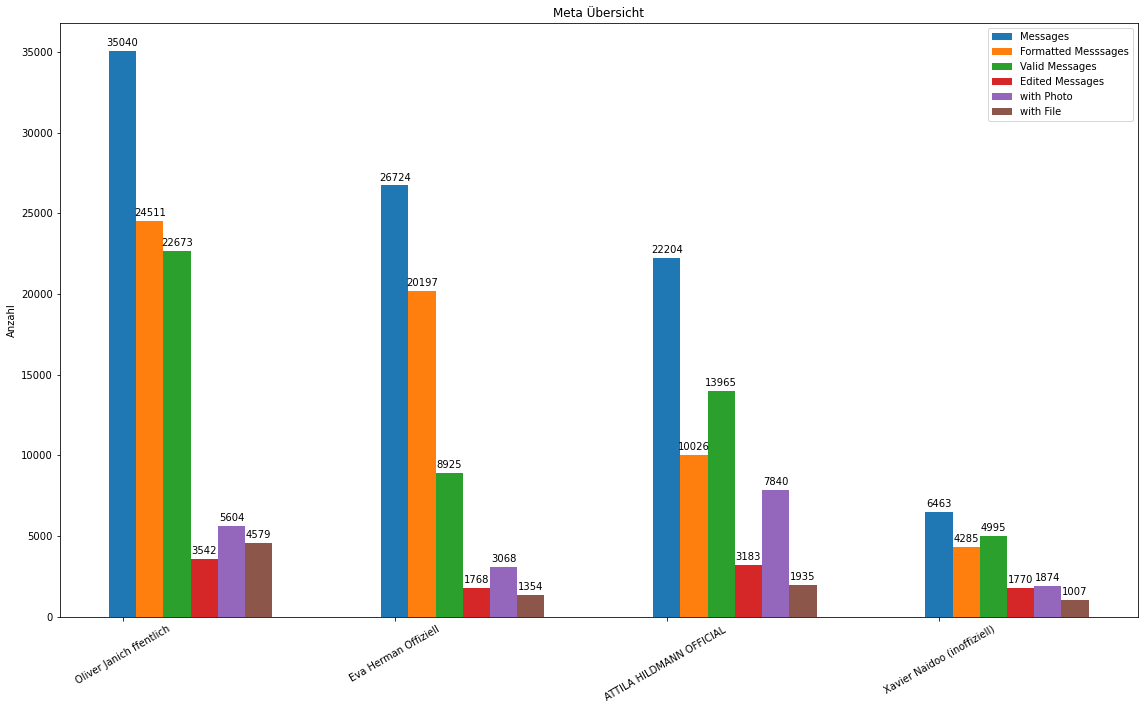

In [195]:
queryMetaPlotter()

## Get valid text

In [44]:
def normalizedValidTextSize(df):
    df = df.copy()
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
    return df[np.abs(df.processedValidTextSize-df.processedValidTextSize.mean()) <= (3*df.processedValidTextSize.std())]

Before all filters		114832
Before normalizedValidTextSize	68704
After normalizedValidTextSize	67126


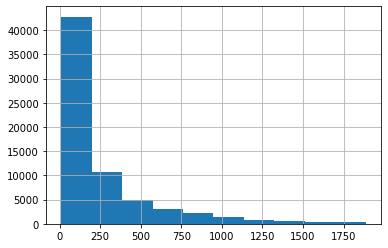

In [45]:
dfMessages = dfAllDataMessages.copy()
print("Before all filters\t\t" + str(len(dfMessages.index)))

dfMessages = dfMessages[dfMessages.processedValidTextSize > 10]
print("Before normalizedValidTextSize\t" + str(len(dfMessages.index)))

dfMessages = normalizedValidTextSize(dfMessages)
print("After normalizedValidTextSize\t" + str(len(dfMessages.index)))

_ = dfMessages.processedValidTextSize.hist()

## Extract Hashtags

In [46]:
# TODO: Extract hashtags in non formatted text

def extractImportantHashtags(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.astype(str)["processedTextDataHashtags"] != "[]"]

    hashTagList = list()
    for index, row in dfMessages.iterrows():
        for hashtagItem in row["processedTextDataHashtags"]:
            hashTagList.append(hashtagItem)

    return Counter(hashTagList).most_common(20)

In [47]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-25-janich")

[('#StopLeftDystopia', 96),
 ('#Berlin', 40),
 ('#links', 40),
 ('#Messer', 33),
 ('#Einreise', 32),
 ('#Justiz', 32),
 ('#Kosten', 31),
 ('#Netzfund', 24),
 ('#CoronaKrise', 20),
 ('#Clan', 16),
 ('#Hamburg', 16),
 ('#COVID1984_Lüge', 16),
 ('#Orwell', 15),
 ('#Hannover', 14),
 ('#Corona', 14),
 ('#Freiheit', 13),
 ('#GreatAwakening', 13),
 ('#Psychiatrie', 12),
 ('#QAnon', 12),
 ('#NEONREVOLT', 12)]

In [48]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-27-evaherman")

[('#Abendgebet', 56),
 ('#abendgebet', 23),
 ('#StabildurchdenWandel', 22),
 ('#HermanPoppTagesnachricht', 17),
 ('#HildegardvonBingenEH', 14),
 ('#Termin', 5),
 ('#Podcast', 5),
 ('#HildegardvonBingen', 4),
 ('#RUBIKON', 4),
 ('#links', 3),
 ('#CoronaKrise', 3),
 ('#netzfund', 2),
 ('#TalkImHangar7', 2),
 ('#Coronavirus', 2),
 ('#coronavirusdeutschland', 2),
 ('#BillGates', 2),
 ('#KenFM', 2),
 ('#KritischesWeisssein', 2),
 ('#demo', 2),
 ('#Netzfund', 2)]

In [49]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-25-hildmann")

[('#AHMEMO', 9),
 ('#oneLove', 2),
 ('#ALUHUTSITZT', 1),
 ('#EHRENLOS', 1),
 ('#stayathome', 1),
 ('#Don', 1),
 ('#WiederWHOlungstäter', 1),
 ('#Covid1984_LÜGEN', 1),
 ('#maskeauf', 1),
 ('#BlackLivesMatter', 1),
 ('#STAYATHOME', 1),
 ('#STAYSAFE', 1),
 ('#MASKEAUF', 1),
 ('#VERTRAUTGATES', 1),
 ('#DANKEMERKEL', 1),
 ('#optinfoil', 1),
 ('#Rocker', 1),
 ('#KLARTEXT', 1),
 ('#netzfund', 1),
 ('#Netzfund', 1)]

In [50]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-25-xavier")

[('#oneLove', 1335),
 ('#TEAMHEIMAT', 26),
 ('#Metropolnews', 22),
 ('#BRD', 8),
 ('#USA', 7),
 ('#netzfund', 5),
 ('#Coronavirus', 5),
 ('#Wirtschaft', 5),
 ('#Trump', 5),
 ('#Verfassung', 5),
 ('#Russland', 4),
 ('#Ankündigung', 4),
 ('#Freiheit', 4),
 ('#Weltfrieden', 4),
 ('#Corona', 4),
 ('#Berlin', 4),
 ('#Netzfund', 4),
 ('#CoronaKrise', 3),
 ('#Frieden', 3),
 ('#2WK', 3)]

## Extract Urls

In [51]:
# TODO: No Hostname if string startsWith ! "http"
# TODO: Url in non formatted text
# TODO: Add mention and other attributes
# TODO: mention in non formatted text? and other attributes

# TODO: Check if both set (from and from_id, actor, ...)
# TODO: Add cache attributes ^^ from_id -> from (map with validator)

# TODO: Duplicates in refs from text

# Text ref important for finding groups
# forwared_from important for graphs

# Return  Counter forwarded_from
def extractImportantUrls(filePath, debugPrint):
    dfMessages = dictMessages[filePath].copy()

    hostList = list()
    urList   = list()
    refList = list()
    for index, row in dfMessages.iterrows():
        if(str(row["processedTextDataURLs"]) != "[]"):
            for urlItem in row["processedTextDataURLs"]:
                urlData = urlparse(str(urlItem))

                completeHostname = urlData.hostname
                completeUrl      = urlData.geturl()

                hostList.append(str(completeHostname))
                urList.append(str(completeUrl))

                if "t.me" in str(completeHostname):
                    refList.append(str(completeUrl))
            
    forwardedFromList = list()
    if("forwarded_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():        
            forwardedFromList.append(str(row["forwarded_from"]))
            
    actorList = list()
    if("actor" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            actorList.append(str(row["actor"]))
    
    memberList = list()
    if("members" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            if(str(row["members"]) != "nan"):
                for memberItem in row["members"]:
                    memberList.append(str(memberItem))
                    
    fromList = list()
    if("from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            fromList.append(str(row["from"]))
            
    savedFromList = list()
    if("saved_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            savedFromList.append(str(row["saved_from"]))
        
    if(debugPrint):
        print("########################################")
        print("###### Top 20 Hosts ####################")
        print("########################################")
        print ("\n".join(map(str, Counter(hostList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 URLs #####################")
        print("########################################")
        print ("\n".join(map(str, Counter(urList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs from text ###########")
        print("########################################")
        print ("\n".join(map(str, Counter(refList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (forwarded_from) ####")
        print("########################################")
        print ("\n".join(map(str, Counter(forwardedFromList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (actor) #############")
        print("########################################")
        print ("\n".join(map(str, Counter(actorList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (members) ###########")
        print("########################################")
        print ("\n".join(map(str, Counter(memberList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (from) ##############")
        print("########################################")
        print ("\n".join(map(str, Counter(fromList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (saved_from) ########")
        print("########################################")
        print ("\n".join(map(str, Counter(savedFromList).most_common(20))))
        print()
    
    return Counter(forwardedFromList)

In [52]:
_ = extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-25-janich", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('www.youtube.com', 2320)
('www.journalistenwatch.com', 1585)
('youtu.be', 1558)
('twitter.com', 1529)
('www.bild.de', 1004)
('www.welt.de', 952)
('www.focus.de', 922)
('t.me', 857)
('t.co', 809)
('www.epochtimes.de', 765)
('19vierundachtzig.com', 516)
('None', 416)
('focus.de', 410)
('www.n-tv.de', 387)
('jungefreiheit.de', 385)
('www.spiegel.de', 383)
('deutsch.rt.com', 266)
('www.faz.net', 253)
('www.tagesschau.de', 246)
('www.tichyseinblick.de', 219)

########################################
###### Top 20 URLs #####################
########################################
('https://t.me/Corona_Fakten/242', 59)
('https://t.me/Corona_Fakten', 41)
('http://www.expresszeitung.com/?atid=58', 39)
('https://t.me/coronainformationskanal', 35)
('Bild.de', 30)
('https://shop.expresszeitung.com/shop/shop/alle-ausgaben/ausgabe_33.html?atid=58', 24)
('t.me/Wirsindvielmehr',

In [53]:
_ = extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-27-evaherman", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('www.youtube.com', 2123)
('www.welt.de', 1660)
('www.kopp-verlag.de', 1187)
('www.epochtimes.de', 1164)
('www.focus.de', 987)
('www.tichyseinblick.de', 894)
('www.journalistenwatch.com', 874)
('de.sputniknews.com', 789)
('www.faz.net', 784)
('deutsch.rt.com', 702)
('jungefreiheit.de', 575)
('www.spiegel.de', 517)
('www.bild.de', 474)
('www.achgut.com', 449)
('c.kopp-verlag.de', 370)
('www.anti-spiegel.ru', 302)
('youtu.be', 298)
('www.rubikon.news', 259)
('twitter.com', 213)
('www.n-tv.de', 203)

########################################
###### Top 20 URLs #####################
########################################
('https://amzn.to/2VR6Evg', 65)
('https://www.kopp-verlag.de/Im-Lichte-der-Wahrheit.htm?websale8=kopp-verlag&pi=B4588822&ci=%24_AddOn_%24&&6=8485245', 55)
('https://www.kopp-verlag.de/a/corona-fehlalarm--3?d=1&&6=8991273', 42)
('https://c.kopp-verlag.

In [54]:
_ = extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-25-hildmann", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('youtu.be', 1413)
('www.youtube.com', 380)
('t.me', 355)
('www.bitchute.com', 174)
('None', 142)
('bit.ly', 135)
('www.spiegel.de', 120)
('www.welt.de', 114)
('amzn.to', 104)
('de.m.wikipedia.org', 76)
('www.instagram.com', 72)
('www.n-tv.de', 66)
('www.t-online.de', 54)
('www.tagesschau.de', 52)
('de.wikipedia.org', 51)
('twitter.com', 46)
('www.zeit.de', 46)
('www.rnd.de', 42)
('www.bild.de', 38)
('www.facebook.com', 36)

########################################
###### Top 20 URLs #####################
########################################
('https://bit.ly/37OCsH5', 93)
('https://www.bitchute.com/video/5izjzGo5AyBw/', 42)
('https://t.me/gerechtigkeitfuersvaterland', 26)
('https://youtu.be/o_cDlU86u48', 23)
('https://t.me/DEMOKRATENCHAT', 21)
('https://t.me/ChatDerFreiheit', 20)
('www.attilahildmann.de/alles?pc=SAMURAIPARTEI', 19)
('https://id4d.worldbank.org/

In [55]:
_ = extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-25-xavier", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('youtu.be', 1047)
('t.me', 321)
('www.youtube.com', 173)
('None', 150)
('twitter.com', 124)
('music.youtube.com', 45)
('www.facebook.com', 41)
('www.bild.de', 35)
('www.welt.de', 32)
('www.journalistenwatch.com', 22)
('www.metropolnews.info', 22)
('www.focus.de', 20)
('t.co', 19)
('open.spotify.com', 19)
('de.m.wikipedia.org', 17)
('www.epochtimes.de', 16)
('www.n-tv.de', 16)
('www.xaviernaidoo.de', 14)
('www.rnd.de', 13)
('www.legitim.ch', 12)

########################################
###### Top 20 URLs #####################
########################################
('t.me/fufmedia', 32)
('https://twitter.com/HGMaassen', 12)
('https://www.youtube.com/watch?v=-qlXjhbUZnA', 12)
('https://t.me/Daniel_Prinz_Offiziell', 11)
('http://t.me/QanonAustria', 10)
('www.facebook.com/QanonAustria', 10)
('https://t.me/Demotermine', 9)
('t.me/Q_D_R_A', 9)
('https://t.me/Livestrea

In [56]:
# Just for test purposes
_ = extractImportantUrls("DS-22-10-2020/ChatExport_2020-10-13-xavierChat", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('t.me', 1815)
('youtu.be', 624)
('m.freemake.com', 356)
('keepvid.pro', 356)
('politaufkleber.de', 356)
('None', 136)
('www.youtube.com', 115)
('twitter.com', 82)
('www.facebook.com', 36)
('www.welt.de', 25)
('www.metropolnews.info', 21)
('www.bild.de', 20)
('www.journalistenwatch.com', 13)
('telegra.ph', 13)
('de.m.wikipedia.org', 13)
('www.focus.de', 13)
('www.epochtimes.de', 10)
('www.legitim.ch', 10)
('m.bild.de', 9)
('19vierundachtzig.com', 9)

########################################
###### Top 20 URLs #####################
########################################
('https://m.freemake.com/de/free_video_downloader/', 356)
('https://t.me/Gozilla_bot', 356)
('https://keepvid.pro/de24/', 356)
('http://t.me/WIR_sind_viel_mehr', 356)
('https://t.me/EinleitungHilfeTelegram', 356)
('https://politaufkleber.de/produkt/teamxavier-telegram-fangruppen-shirt-auswahl/', 35

## Word Clouds

In [57]:
#TODO Difference capital letters?
#TODO Context?

# Use "global" for all DataFrames
def plotChannelWordCloud(filePath, label, filterList):
    timeStart = time.time()
    
    if(filePath != "global"):
        dfMessages = dictMessages[filePath].copy()
    else:
        dfMessages = dfAllDataMessages.copy()
    
    print("[Start transform text to global text string]")
    textList = []
    for index, row in dfMessages.iterrows():
        textList.append(" " + row["processedValidText"])
        
    textString = ''.join(textList)
    
    germanStopWordsList = nltk.corpus.stopwords.words('german')
    germanStopWordsList.append("http")
    germanStopWordsList.append("https")
    germanStopWordsList.append("ja") #TODO: split to local - maybe?
    germanStopWordsList.append("nein")
    germanStopWordsList.append("mehr")
    germanStopWordsList.append("mal")
    germanStopWordsList.append("schon")
    germanStopWordsList.append("immer")
    germanStopWordsList.append("wurde")
    germanStopWordsList.append("wurden")
    germanStopWordsList.append("sei")
    germanStopWordsList.append("sein")
    germanStopWordsList.append("viel")
    germanStopWordsList.append("viele")
    germanStopWordsList.append("wegen")
    germanStopWordsList.append("müssen")
    germanStopWordsList.append("geht")
    germanStopWordsList.append("gibt")
    germanStopWordsList.append("wer")
    germanStopWordsList.append("wie")
    germanStopWordsList.append("was")
    germanStopWordsList.append("macht")
    germanStopWordsList.append("machen")
    germanStopWordsList.append("machte")
    germanStopWordsList.append("kommen")
    germanStopWordsList.append("kommt")
    germanStopWordsList.append("glaube")
    germanStopWordsList.append("glaubst")
    germanStopWordsList.append("tun")
    germanStopWordsList.append("wäre")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sagten")
    germanStopWordsList.append("hat")
    germanStopWordsList.append("hast")
    germanStopWordsList.append("haben")
    germanStopWordsList.append("habt")
    germanStopWordsList.append("statt")
    germanStopWordsList.append("genau")
    germanStopWordsList.append("sagen")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sagten")
    germanStopWordsList.append("bitte")
    germanStopWordsList.append("bitten")
    germanStopWordsList.append("danke")
    germanStopWordsList.append("dank")
    germanStopWordsList.append("sollen")
    germanStopWordsList.append("soll")
    germanStopWordsList.append("sollte")
    germanStopWordsList.append("sehen")
    germanStopWordsList.append("seht")
    germanStopWordsList.append("zeigen")
    germanStopWordsList.append("zeigt")
    germanStopWordsList.append("sei")
    germanStopWordsList.append("sein")
    germanStopWordsList.append("seid")
    germanStopWordsList.append("seit")
    germanStopWordsList.append("laut")
    germanStopWordsList.append("lauten")
    germanStopWordsList.append("sehen")
    germanStopWordsList.append("seht")
    germanStopWordsList.append("haben")
    germanStopWordsList.append("hat")
    germanStopWordsList.append("hätten")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sag")
    germanStopWordsList.append("sagt")
    germanStopWordsList.append("ab")
    germanStopWordsList.append("bei")
    germanStopWordsList.append("beim")
    germanStopWordsList.append("denen")
    germanStopWordsList.append("gab")
    germanStopWordsList.append("ab")
    
    for fItem in filterList:
        germanStopWordsList.append(fItem)
    
    print("[Start generate wordCloud]")
    wordcloud = WordCloud(
                background_color="black",
                width=1920,
                height=1080,
                stopwords=germanStopWordsList
            ).generate(textString)
    wordcloud.to_file(dir_var_output + "wordcloud-" + label + ".png")
    
    print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
    
    print("[Start generate figure]")
    plt.figure(figsize=(14, 14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart))

### Public channels

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Deutschland    1.000000
Menschen       0.777668
Video          0.774704
Polizei        0.609190
bereit         0.540020
Berlin         0.465909
Corona         0.420455
Prozent        0.414032
neue           0.398715
AfD            0.389822
dabei          0.381423
Fall           0.371047
Welt           0.368577
and            0.368577
Kinder         0.364625
a              0.362154
heute          0.361660
deutschen      0.354249
Trump          0.350296
seien          0.347332
dtype: float64
[Start generate figure]


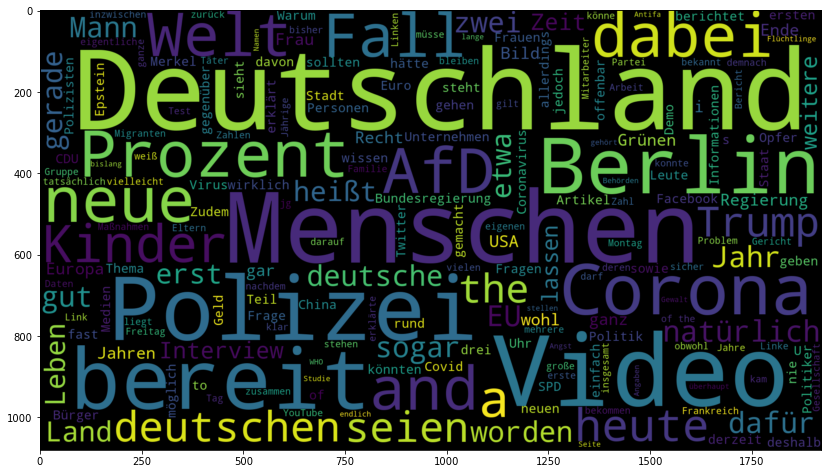

[Finished]
11.623s


In [58]:
# Oliver Janich öffentlich (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-janich",
    "pc-janich",
    []
)

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Menschen       1.000000
Deutschland    0.669903
heute          0.593620
Corona         0.540915
Video          0.450069
Welt           0.424411
bereit         0.408460
Coronavirus    0.384189
Kinder         0.383495
Zeit           0.382108
Liebe Eva      0.371706
China          0.360610
Virus          0.348128
Leben          0.321775
Zuschrift      0.319001
Berlin         0.316921
USA            0.306519
Polizei        0.291956
Eva Herman     0.283634
gerade         0.278086
dtype: float64
[Start generate figure]


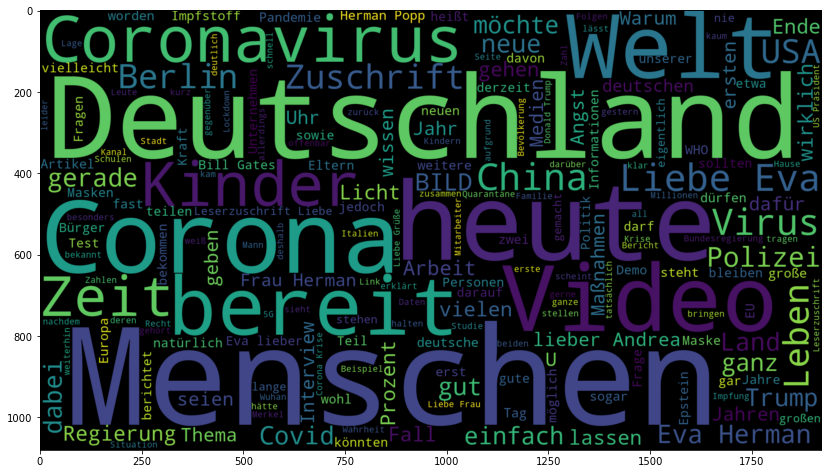

[Finished]
9.438s


In [59]:
# Eva Herman Offiziell (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-27-evaherman",
    "pc-evaHerman",
    []
)

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Deutschland                  1.000000
Corona                       0.751402
Gate                         0.626168
Merkel                       0.593458
Menschen                     0.576636
WOLF ATTILAHILDMANN          0.486916
China                        0.484112
ATTILAHILDMANN CHAT          0.457009
CHAT BEITRETEN               0.453271
BEITRETEN ChatDerFreiheit    0.449533
heute                        0.438318
FOLG                         0.390654
Video                        0.373832
Freiheit                     0.373832
deutschen                    0.363551
einfach                      0.362617
NWO                          0.341121
Welt                         0.302804
ATTILA HILDMANN              0.300935
Zeit                         0.270093
dtype: float64
[Start generate figure]


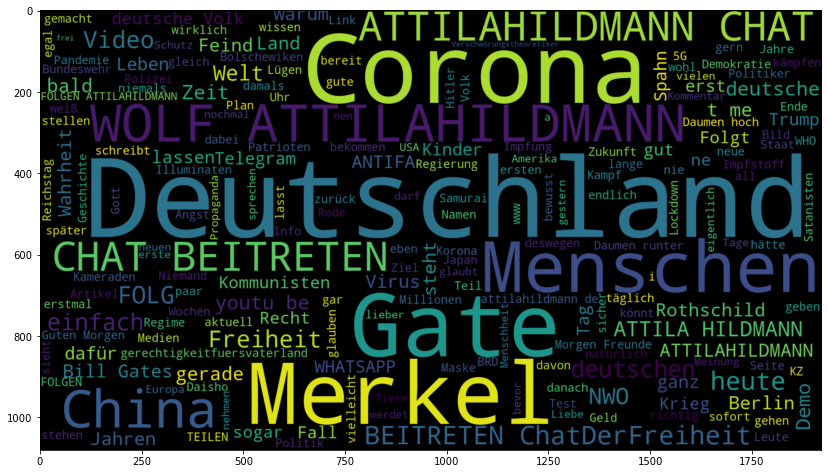

[Finished]
8.165s


In [60]:
# ATTILA HILDMANN OFFICIAL (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-hildmann",
    "pc-hildmann",
    ["ATTILAHILDMANN CHAT"]
)

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
oneLove          1.000000
Menschen         0.256331
Video            0.153799
Deutschland      0.151328
Corona           0.142063
Kinder           0.126004
Wahrheit         0.119827
Berlin           0.114886
Kanäle           0.109944
Liebe            0.096973
Warum            0.096973
einfach          0.092032
heute            0.089561
Zeit             0.088326
Polizei          0.088326
Demo             0.088326
bereit           0.084620
Welt             0.080914
lassen           0.075355
Xavier Naidoo    0.075355
dtype: float64
[Start generate figure]


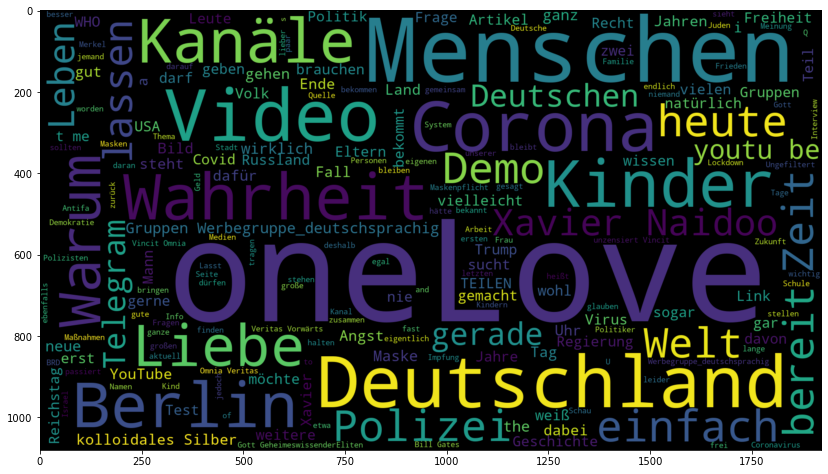

[Finished]
6.046s


In [61]:
# Xavier Naidoo (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-xavier",
    "pc-xavier",
    ["xavier_naidoo", "Xavier_Naidoo", "politische_bildersprueche", "einmal_hin_alles_drin"]
)

In [62]:
# Gerechtigkeit für das Vaterland (public_channel)
#plotChannelWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland",
#    "pc-GerechtigkeitfuerdasVaterland",
#    ["gerechtigkeitfuersvaterland"]
#)

In [63]:
# Corona Virus Informationen (public_channel)
#plotChannelWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo",
#    "pc-cVirusInfo",
#    [])

In [64]:
# Liberté (public_channel)
#plotChannelWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-26-liberte",
#    "pc-liberte",
#    []
#)

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Menschen                 1.000000
Deutschland              0.865236
Video                    0.617918
heute                    0.474308
Corona                   0.454169
Welt                     0.403350
einfach                  0.400339
Kinder                   0.399021
bereit                   0.395445
Berlin                   0.389987
Polizei                  0.386599
oneLove Xavier_Naidoo    0.377188
Recht                    0.356108
Gruppe                   0.350649
Leben                    0.311688
gut                      0.307736
Warum                    0.305101
dabei                    0.303783
gerade                   0.301713
natürlich                0.292302
dtype: float64
[Start generate figure]


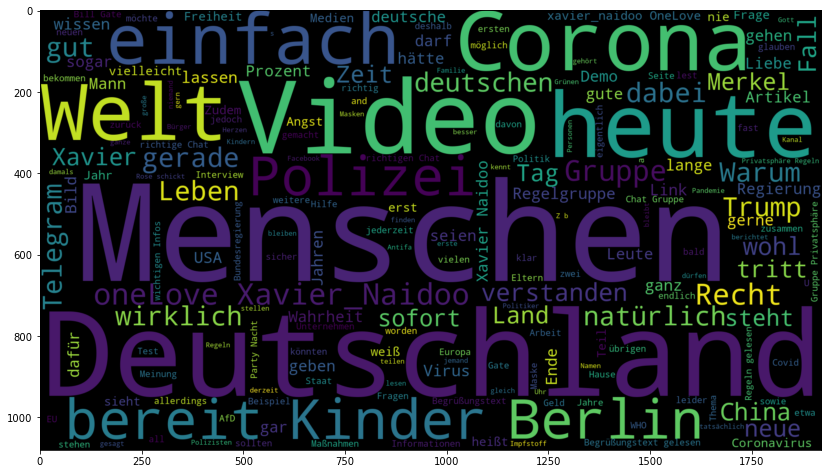

[Finished]
21.512s


In [65]:
# Just for test purposes
plotChannelWordCloud(
    "global",
    "global",
    []
)

## Graphs

### !!!!!!!!!!!!!!!! Quick Filter !!!!!!!!!!!!!!!!!!!!

In [66]:
# Take only samples
#dfFilter = pd.DataFrame()

#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Xavier")])
#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Janich")])
#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Eva")])
#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Janich") == False])

#dfInputFiles = dfFilter

In [67]:
def addNodeSize(label, newSize, targetDict):
    
    if(label in targetDict):
        oldSize = targetDict[label]
        if(newSize > oldSize):
            targetDict[label] = newSize
    else:
        targetDict[label] = newSize

In [68]:
# TODO Nan?
# TODO https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
# (try different layouts e.g. circular_layout)
# TODO: Refactor group title
# TODO: Dont add empty group names (no ref!)    
    
def generateGraph(configMostCount, configAboveCount):
    
    dicNodeSize = dict()
    
    print("[Start generating graph...]")
    timeStart = time.time()
    
    G_weighted = nx.DiGraph()
    
    print("[Add edges]")
    for fP in dfInputFiles.inputPath:
        
        groupName = queryChannelName(fP)
        groupSize = queryChannelCountEntries(fP)

        print("- Process now >>" + groupName + "<< (" + str(groupSize) + ")")
        
        mostCounter = extractImportantUrls(fP, debugPrint=False)
        mostCounter = mostCounter.most_common(configMostCount)

        addNodeSize(groupName, groupSize, dicNodeSize)
        
        for gRN, gRS in mostCounter:
            
            groupRefName    = str(gRN)
            groupRefSize    = gRS

            if(groupRefName != "nan" and groupRefSize > configAboveCount):
                
                groupRefName = groupRefName.encode('ascii', 'ignore')
                groupRefName = groupRefName.decode('ascii')
                groupRefName = groupRefName[:25]
                
                #Debug Print
                #print("- Add >>" + groupRefName + "<< (" + str(groupRefSize) + ")")
            
                addNodeSize(groupRefName, groupRefSize, dicNodeSize)
                G_weighted.add_edge(groupName, groupRefName, weight=groupRefSize)
        
    print("[Add different node sizes]")
    for aNode in dicNodeSize:
        
        nodeName = str(aNode)
        nodeSize = dicNodeSize[aNode]
        
        #Debug Print
        #print("- Add Node >>" + nodeName + "<< (" + str(nodeSize) + ")")
        
        G_weighted.add_node(nodeName, weight=nodeSize)
        
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart))    
        
    return G_weighted

In [69]:
def drawAndSavePlot(G, factorEdge, factorNode, factorArrowSize, graphHeight, graphWidth, outputFilename):
    
    print("[Draw]")
    timeStart = time.time()
    
    plt.figure(figsize=(graphHeight,graphWidth))
        
    pos = nx.nx_pydot.graphviz_layout(G)
    
    #Clean edges
    edges = nx.get_edge_attributes(G, "weight")
    clean_edges = dict()
    
    for key in edges:
        
        value = edges[key]
        value = value / factorEdge
        
        clean_edges[key] = value
    
    
    #Clean nodes
    nodes = nx.get_node_attributes(G,'weight')
    clean_nodes = dict()
    
    for key in nodes:
        
        value = nodes[key]
        value = value / factorNode
        
        clean_nodes[key] = value
        
    nx.draw(G,
        pos,
        #node_color='lightgreen',
        with_labels=True,
        #edge_color=colors, 
        width=list(clean_edges.values()),
        #edge_labels=edge_labels,
        node_size=list(clean_nodes.values()),
        arrowsize=factorArrowSize,
    )
        
    edge_labels = nx.get_edge_attributes(G, "weight")
    
    _ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.savefig(dir_var_output + outputFilename)
    plt.show()
    
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart)) 

In [70]:
generatedGraph = generateGraph(
    configMostCount = 50,
    configAboveCount = 50,
)

[Start generating graph...]
[Add edges]
- Process now >>Xavier Naidoo (inoffiziel<< (6463)
- Process now >>Regellese und Diskussions<< (24401)
- Process now >>Oliver Janich ffentlich<< (35040)
- Process now >>Eva Herman Offiziell<< (26724)
- Process now >>ATTILA HILDMANN OFFICIAL << (22204)
[Add different node sizes]
[Finished]
23.097s


In [71]:
drawAndSavePlot(
    generatedGraph,
    factorEdge = 1000,
    factorNode = 10,
    factorArrowSize = 5,
    graphHeight = 100,
    graphWidth = 100,
    outputFilename = "graph.png"
)

[Draw]


[Finished]
8.833s


In [72]:
#G_weighted = nx.DiGraph()

#G_weighted.add_edge('A', 'B', weight=8)
#G_weighted.add_edge('A', 'C', weight=2)
#G_weighted.add_edge('A', 'D', weight=5)
#G_weighted.add_edge('C', 'D', weight=3)
#G_weighted.add_edge('A', 'C', weight=2)
#G_weighted.add_edge('D', 'C', weight=10)
#G_weighted.add_edge('C', 'E', weight=5)

#G_weighted.add_node('A', weight=500)
#G_weighted.add_node('C', weight=300)
#G_weighted.add_node('D', weight=500)
#G_weighted.add_node('B', weight=600)
#G_weighted.add_node('E', weight=500)

In [73]:
#from ipywidgets import interact
#import ipywidgets as widgets

In [74]:
#interact(plot_random_graph, n=(2,30), m=(1,10), k=(1,10), p=(0.0, 1.0, 0.001),
#         generator={
#             'lobster': random_lobster,
#             'power law': powerlaw_cluster,
#             'Newman-Watts-Strogatz': newman_watts_strogatz,
#             u'Erdős-Rényi': erdos_renyi,
#         });

## Concordance

In [75]:
#tbd